# Importing The Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from skimage.util import random_noise
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Loading The Image

In [2]:
camera_man = data.camera()
original_image = camera_man.astype(float)

print(f"Image shape: {original_image.shape}")
print(f"Image range: [{original_image.min():.1f}, {original_image.max():.1f}]")

Image shape: (512, 512)
Image range: [0.0, 255.0]


# Deleting The Pixels + Visualization

In [3]:
def create_missing_pixels(image, missing_ratio):
    image_copy = image.copy()
    mask = np.ones_like(image, dtype=bool)

    total_pixels = image.size
    missing_count = int(total_pixels * missing_ratio)

    flat_indices = np.random.choice(total_pixels, missing_count, replace=False)
    missing_indices = np.unravel_index(flat_indices, image.shape)

    image_copy[missing_indices] = np.nan
    mask[missing_indices] = False

    return image_copy, mask

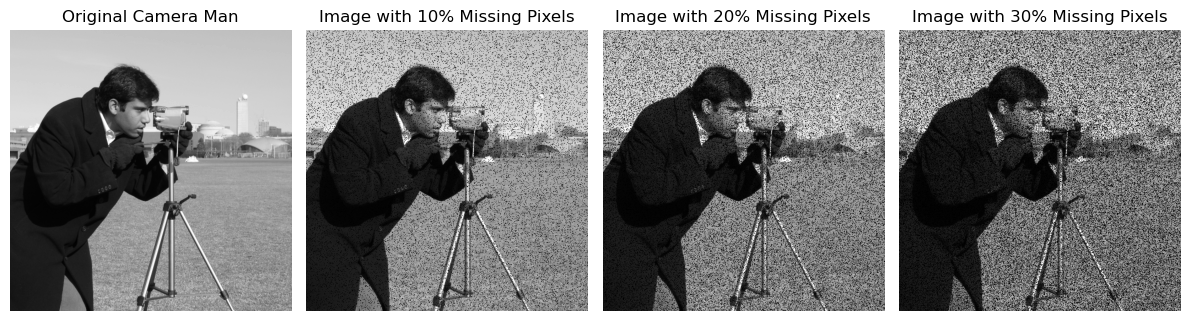

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 10))

# Plot 1: Original image
axes[0].imshow(original_image, cmap='gray');
axes[0].set_title('Original Camera Man')
axes[0].axis('off')

# Plot 2: Image with 10% missing pixels
image_missing_10, mask_10 = create_missing_pixels(original_image, 0.1)
axes[1].imshow(np.where(mask_10, original_image, 0), cmap='gray');
axes[1].set_title('Image with 10% Missing Pixels')
axes[1].axis('off')

# Plot 3: Image with 20% missing pixels
image_missing_20, mask_20 = create_missing_pixels(original_image, 0.2)
axes[2].imshow(np.where(mask_20, original_image, 0), cmap='gray');
axes[2].set_title('Image with 20% Missing Pixels')
axes[2].axis('off')

# Plot 4: Image with 20% missing pixels
image_missing_30, mask_30 = create_missing_pixels(original_image, 0.3)
axes[3].imshow(np.where(mask_30, original_image, 0), cmap='gray');
axes[3].set_title('Image with 30% Missing Pixels')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Reconstruction

In [5]:
def mean_imputation(image, mask):
    reconstructed = image.copy()
    mean_val = np.nanmean(image)
    reconstructed[~mask] = mean_val
    return reconstructed

def gaussian_noise_imputation(image, mask):
    reconstructed = image.copy()
    available_pixels = image[mask]
    mean_val = np.mean(available_pixels)
    std_val = np.std(available_pixels)
    
    missing_count = np.sum(~mask)
    noise = np.random.normal(mean_val, std_val, missing_count)
    reconstructed[~mask] = noise
    return reconstructed

def uniform_noise_imputation(image, mask):
    reconstructed = image.copy()
    available_pixels = image[mask]
    min_val = np.min(available_pixels)
    max_val = np.max(available_pixels)
    
    missing_count = np.sum(~mask)
    noise = np.random.uniform(min_val, max_val, missing_count)
    reconstructed[~mask] = noise
    return reconstructed

def linear_regression_imputation(image, mask):
    reconstructed = image.copy()
    
    y_coords, x_coords = np.indices(image.shape)
    
    train_mask = mask.flatten()
    X_train = np.column_stack([x_coords.flatten()[train_mask], 
                              y_coords.flatten()[train_mask]])
    y_train = image.flatten()[train_mask]
    
    test_mask = ~mask.flatten()
    X_test = np.column_stack([x_coords.flatten()[test_mask], 
                             y_coords.flatten()[test_mask]])
    
    if len(X_test) > 0:
        # Train linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict missing values
        y_pred = model.predict(X_test)
        reconstructed[~mask] = y_pred
    
    return reconstructed

def polynomial_regression_imputation(image, mask, degree=2):
    reconstructed = image.copy()
    
    y_coords, x_coords = np.indices(image.shape)
    
    train_mask = mask.flatten()
    X_train = np.column_stack([x_coords.flatten()[train_mask], 
                              y_coords.flatten()[train_mask]])
    y_train = image.flatten()[train_mask]
    
    test_mask = ~mask.flatten()
    X_test = np.column_stack([x_coords.flatten()[test_mask], 
                             y_coords.flatten()[test_mask]])
    
    if len(X_test) > 0:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('linear', LinearRegression())
        ])
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        reconstructed[~mask] = y_pred
    
    return reconstructed

def ridge_regression_imputation(image, mask, alpha=1.0):

    reconstructed = image.copy()
  
    y_coords, x_coords = np.indices(image.shape)
    
    train_mask = mask.flatten()
    X_train = np.column_stack([x_coords.flatten()[train_mask], 
                              y_coords.flatten()[train_mask]])
    y_train = image.flatten()[train_mask]
    
    test_mask = ~mask.flatten()
    X_test = np.column_stack([x_coords.flatten()[test_mask], 
                             y_coords.flatten()[test_mask]])
    
    if len(X_test) > 0:
        # Train Ridge regression model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Predict missing values
        y_pred = model.predict(X_test)
        reconstructed[~mask] = y_pred
    
    return reconstructed

def lasso_regression_imputation(image, mask, alpha=0.1):
   
    reconstructed = image.copy()
    
    y_coords, x_coords = np.indices(image.shape)
    
    train_mask = mask.flatten()
    X_train = np.column_stack([x_coords.flatten()[train_mask], 
                              y_coords.flatten()[train_mask]])
    y_train = image.flatten()[train_mask]
    
    test_mask = ~mask.flatten()
    X_test = np.column_stack([x_coords.flatten()[test_mask], 
                             y_coords.flatten()[test_mask]])
    
    if len(X_test) > 0:
        # Train Lasso regression model
        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_train, y_train)
        
        # Predict missing values
        y_pred = model.predict(X_test)
        reconstructed[~mask] = y_pred
    
    return reconstructed


In [6]:
missing_ratios = [0.1, 0.2, 0.3]
methods = {
    'Mean Imputation': mean_imputation,
    'Gaussian Noise': gaussian_noise_imputation,
    'Uniform Noise': uniform_noise_imputation,
    'Linear Regression': linear_regression_imputation,
    'Ridge Regression': lambda img, mask: ridge_regression_imputation(img, mask, alpha=1.0),
    'Lasso Regression': lambda img, mask: lasso_regression_imputation(img, mask, alpha=0.1)
}

In [7]:
# Add polynomial regression for degrees 1 to 10
for degree in range(1, 11):
    methods[f'Polynomial (deg={degree})'] = lambda img, mask, deg=degree: polynomial_regression_imputation(img, mask, deg)

In [8]:
np.random.seed(42)

In [9]:
results = []
for missing_ratio in missing_ratios:
    print(f"\nProcessing missing ratio: {missing_ratio*100}%")
    
    image_with_missing, mask = create_missing_pixels(original_image, missing_ratio)
    
    for method_name, method_func in methods.items():
        reconstructed = method_func(image_with_missing, mask)
        
        # Ensure images are in valid range for SSIM
        reconstructed_clipped = np.clip(reconstructed, 0, 255)
        ssim_score = metrics.structural_similarity(
            original_image, reconstructed_clipped, 
            data_range=original_image.max() - original_image.min()
        )
        
        results.append({
            'Missing Ratio': missing_ratio,
            'Method': method_name,
            'SSIM': ssim_score
        })
        
        print(f"  {method_name}: SSIM = {ssim_score:.4f}")


Processing missing ratio: 10.0%
  Mean Imputation: SSIM = 0.4377
  Gaussian Noise: SSIM = 0.3043
  Uniform Noise: SSIM = 0.2915
  Linear Regression: SSIM = 0.5634
  Ridge Regression: SSIM = 0.5634
  Lasso Regression: SSIM = 0.5634
  Polynomial (deg=1): SSIM = 0.5634
  Polynomial (deg=2): SSIM = 0.5960
  Polynomial (deg=3): SSIM = 0.6707
  Polynomial (deg=4): SSIM = 0.7086
  Polynomial (deg=5): SSIM = 0.7493
  Polynomial (deg=6): SSIM = 0.7451
  Polynomial (deg=7): SSIM = 0.7535
  Polynomial (deg=8): SSIM = 0.7657
  Polynomial (deg=9): SSIM = 0.7654
  Polynomial (deg=10): SSIM = 0.5031

Processing missing ratio: 20.0%
  Mean Imputation: SSIM = 0.3540
  Gaussian Noise: SSIM = 0.1840
  Uniform Noise: SSIM = 0.1731
  Linear Regression: SSIM = 0.4619
  Ridge Regression: SSIM = 0.4619
  Lasso Regression: SSIM = 0.4619
  Polynomial (deg=1): SSIM = 0.4619
  Polynomial (deg=2): SSIM = 0.4866
  Polynomial (deg=3): SSIM = 0.5680
  Polynomial (deg=4): SSIM = 0.6083
  Polynomial (deg=5): SSIM = 0.

In [10]:
results_df = pd.DataFrame(results)

summary_table = results_df.pivot_table(
    index='Method', 
    columns='Missing Ratio', 
    values='SSIM',
    aggfunc='mean'
)

print("Summary Table (SSIM Scores)\n")
print(summary_table.round(4))

Summary Table (SSIM Scores)

Missing Ratio           0.1     0.2     0.3
Method                                     
Gaussian Noise       0.3043  0.1840  0.1336
Lasso Regression     0.5634  0.4619  0.4030
Linear Regression    0.5634  0.4619  0.4030
Mean Imputation      0.4377  0.3540  0.3036
Polynomial (deg=1)   0.5634  0.4619  0.4030
Polynomial (deg=10)  0.5031  0.4939  0.3354
Polynomial (deg=2)   0.5960  0.4866  0.4242
Polynomial (deg=3)   0.6707  0.5680  0.5062
Polynomial (deg=4)   0.7086  0.6083  0.5465
Polynomial (deg=5)   0.7493  0.6563  0.5968
Polynomial (deg=6)   0.7451  0.6516  0.5910
Polynomial (deg=7)   0.7535  0.6601  0.5995
Polynomial (deg=8)   0.7657  0.6716  0.6095
Polynomial (deg=9)   0.7654  0.6769  0.6178
Ridge Regression     0.5634  0.4619  0.4030
Uniform Noise        0.2915  0.1731  0.1213
